In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import re
import json

from IPython.core.display import HTML
pd.options.display.max_columns = 100
import datetime

from IPython.core.display import HTML
import seaborn as sb
sb.set_style("whitegrid")
sb.set_style("white")

import ipywidgets as widgets

import pprint
pp = pprint.PrettyPrinter(indent=4)

HTML("<style>.container { width:100% !important; }</style>")

In [5]:
import spacy

nlp = spacy.load("nl_core_news_sm")
from wordcloud import WordCloud


In [3]:
data_raw = pd.read_excel('raw_data/2021-08-04_FINAL_LABELING_PEILING_VOORUIT volledige versie.xlsx')
data_raw = data_raw.set_index('ID')
data_raw['Opleiding'] = data_raw['Opleiding'] = data_raw['Opleiding'].replace({
    'geef liever geen antwoord':'0_geef liever geen antwoord',
    'lagere school of geen diploma': '1_lagere school of geen diploma',
    'lager algemeen secundair onderwijs (1ste 3 jaar)' : '2_lager algemeen secundair onderwijs (1ste 3 jaar)',
    'lager TSO, BSO of artistiek (1ste 3 jaar)': '2_lager TSO, BSO of artistiek (1ste 3 jaar)',
    'hoger secundair beroepsonderwijs (BSO)': '3_hoger secundair beroepsonderwijs (BSO)',
    'hoger secundair technisch of artistiek onderwijs': '3_hoger secundair technisch of artistiek onderwijs',
    'hoger algemeen secundair onderwijs': '3_hoger algemeen secundair onderwijs',
    'kandidaat, bachelor, graduaat': '4_kandidaat, bachelor, graduaat',
    'licentiaat, master, postgraduaat': '5_licentiaat, master, postgraduaat',
    'licentiaat met aanvullend diploma, MaNaMa': '5_licentiaat met aanvullend diploma, MaNaMa',
    'doctoraat met thesis': '6_doctoraat met thesis',
})

labels_erica = pd.read_csv('raw_data/2021-08-04_FINAL_LABELING_PEILING_VOORUIT.csv')
labels_erica = labels_erica.set_index('ID')
columns = ['Overall sentiment', 'Label positieve woorden Vooruit', 'Label negatieve woorden Vooruit', 'Label verschil']
data_raw = pd.merge(data_raw, labels_erica[columns], left_index=True, right_index=True, how='left')

data_raw.sample(2)

,Gender,Leeftijd,Provincie,Habitat,Opleiding,Beroep,Pot Groen,Pot CD&V,Pot N-VA,Pot Vooruit,Pot VB,Pot VLD,Pot PVDA,Voorkeur,Aversie,Stem 2019,Waarom sp.a in 2019 maar nu niet Vooruit?,Waarom niet sp.a in 2019 maar nu wel?,Vertrouwen BEL regering,Vertrouwen De Croo,Vertrouwen VLA regering,Vertrouwen Jambon,Zelf: links-rechts,Groen: links-rechts,CD&V: links-rechts,N-VA: links-rechts,Vooruit: links-rechts,VB: links-rechts,VLD: links-rechts,PVDA: links-rechts,Zelf: progressief,Groen: progressief,CD&V: progressief,N-VA: progressief,Vooruit: progressief,VB: progressief,VLD: progressief,PVDA: progressief,Zelf: conservatief,Groen: conservatief,CD&V: conservatief,N-VA: conservatief,Vooruit: conservatief,VB: conservatief,VLD: conservatief,PVDA: conservatief,Belang thema’s,Economie: eigenaarschap,Klimaat: eigenaarschap,Milieu: eigenaarschap,...,Egbert Lachaert: Belangrijke rol,Hilde Crevits: Belangrijke rol,Joachim Coens: Belangrijke rol,Wouter Beke: Belangrijke rol,Annelies Verlinden: Belangrijke rol,Meyrem Almaci: Belangrijke rol,Petra De Sutter: Belangrijke rol,Tom Van Grieken: Belangrijke rol,Dries Van Langenhove: Belangrijke rol,Peter Mertens: Belangrijke rol,Bart De Wever: Belangrijke rol,Jan Jambon: Belangrijke rol,Theo Francken: Belangrijke rol,Ben Weyts: Belangrijke rol,Zuhal Demir: Belangrijke rol,Best vertegenwoordigd,Frank Vandenbroucke: indruk minister,Vincent Van Quickenborne: indruk minister,Alexander De Croo: indruk minister,Wouter Beke: indruk minister,Annelies Verlinden: indruk minister,Jan Jambon: indruk minister,Ben Weyts: indruk minister,Joris Vandenbroucke: Kent u ... ?,Freya Vandenbossche: Kent u ... ?,Astrid De Bruycker: Kent u ... ?,Maxim Veys: Kent u ... ?,Melissa Depraetere: Kent u ... ?,Steve Vandenberghe: Kent u ... ?,Annick Lambrecht: Kent u ... ?,Bruno Tobback: Kent u ... ?,Karin Jiroflee: Kent u ... ?,Mohamed Ridouani: Kent u ... ?,Kris Verduyckt: Kent u ... ?,Ludwig Vandenhove: Kent u ... ?,Els Robeyns: Kent u ... ?,Tom Meeuws: Kent u ... ?,Hannes Anaf: Kent u ... ?,Caroline Gennez: Kent u ... ?,Kathleen Van Brempt: Kent u ... ?,Jinnih Beels: Kent u ... ?,Naamsverandering gehoord?,Bron naamsverandering,Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?,Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?,Waarin verschilt Vooruit volgens u van sp.a?,Overall sentiment,Label positieve woorden Vooruit,Label negatieve woorden Vooruit,Label verschil
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
307,Man,36,Antwerpen,GROTE agglomeraties,lager algemeen secundair onderwijs (1ste 3 jaar),Vrij beroep,Ja,Nee,Nee,Nee,Ja,Nee,Nee,Groen,"CD&V,N-VA,Vooruit,VLD,PVDA",Blanco,NaN,NaN,Helemaal geen vertrouwen,Weinig vertrouwen,Helemaal geen vertrouwen,Weinig vertrouwen,In het midden,In het midden,Eerder links,In het midden,Eerder links,Eerder rechts,Uiterst links,Eerder links,Neutraal,Neutraal,Neutraal,Neutraal,Neutraal,Eerder progressief,Neutraal,Neutraal,Neutraal,Neutraal,Eerder niet conservatief,Neutraal,Neutraal,Eerder conservatief,Eerder niet conservatief,Eerder niet conservatief,"Klimaat,Gezondheidszorg",Open VLD,Groen,PVDA,...,Ja,Ja,Nee,Ja,Ja,Ja,Nee,Ja,Ja,Ja,Nee,Ja,Ja,Ja,Ja,Geen van deze,"Noch goed, noch slecht","Noch goed, noch slecht","Noch goed, noch slecht","Noch goed, noch slecht","Noch goed, noch slecht","Noch goed, noch slecht","Noch goed, noch slecht",Nee,Nee,Ja,Nee,Ja,Ja,Nee,Ja,Ja,Nee,Nee,Nee,Nee,Ja,Nee,Ja,Nee,Nee,Ja,TV,geen,veel bla bla,nergens,Negatief,Geen,Ontbreekt daadkracht,Geen
498,Man,58,Oost-Vlaanderen,Andere gemeenten,lager algemeen secundair onderwijs (1ste 3 jaar),Geschoold arbeider,Nee,Nee,Nee,Nee,Nee,Nee,Ja,PVDA,N-VA,Weet niet,NaN,NaN,Helemaal geen vertrouwen,Weinig vertrouwen,Helemaal geen vertrouwen,Helemaal geen vertrouwen,Eerder rechts,In het midden,In het midden,In het midden,Eerder rechts,Eerder rechts,In het midden,Eerder rechts,Eerder progressief,Neutraal,Neutraal,Neutraal,Neutraal,Eerder progressief,Neutraal,Eerder pr

## Beschrijvende statistieken

,Leeftijd_cat,Mannen,Vrouwen,Leeftijd
0,100 jaar en meer,0.004999,0.024756,102.5
1,95-99 jaar,0.098765,0.300719,97.5
2,90-94 jaar,0.535620,1.169369,92.5
3,85-89 jaar,1.579211,2.573310,87.5
4,80-84 jaar,2.670082,3.539043,82.5


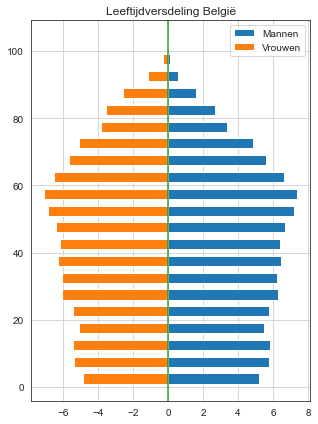

In [25]:
# Leeftijdsverdeling Belgische bevolking
leeftijdsverdeling = pd.read_csv('raw_data/2021-01-16 Leeftijdsverdeling België.csv')

leeftijdsverdeling = leeftijdsverdeling.rename(columns={'Leeftijd': 'Leeftijd_cat'})
leeftijdsverdeling['Leeftijd'] = leeftijdsverdeling['Leeftijd_cat'].str.extract(r'(?P<Leeftijd>[0-9]*)[- ]')
leeftijdsverdeling.loc[leeftijdsverdeling['Leeftijd_cat']=='Minder dan 5 jaar', 'Leeftijd'] = 0
leeftijdsverdeling['Leeftijd'] = leeftijdsverdeling['Leeftijd'].astype(float) + 2.5

leeftijdsverdeling['Mannen'] = leeftijdsverdeling['Mannen']*100/leeftijdsverdeling['Mannen'].sum()
leeftijdsverdeling['Vrouwen'] = leeftijdsverdeling['Vrouwen']*100/leeftijdsverdeling['Vrouwen'].sum()

fig, ax = plt.subplots(1,1, figsize=(5,7))

ax.barh(y=leeftijdsverdeling['Leeftijd'], width=leeftijdsverdeling['Mannen'], height=3, label='Mannen')
ax.barh(y=leeftijdsverdeling['Leeftijd'], width=-leeftijdsverdeling['Vrouwen'], height=3, label='Vrouwen')
ax.axvline(0, c='C2')

ax.set_title('Leeftijdversdeling België')
ax.legend()
ax.grid()

leeftijdsverdeling.head(5)

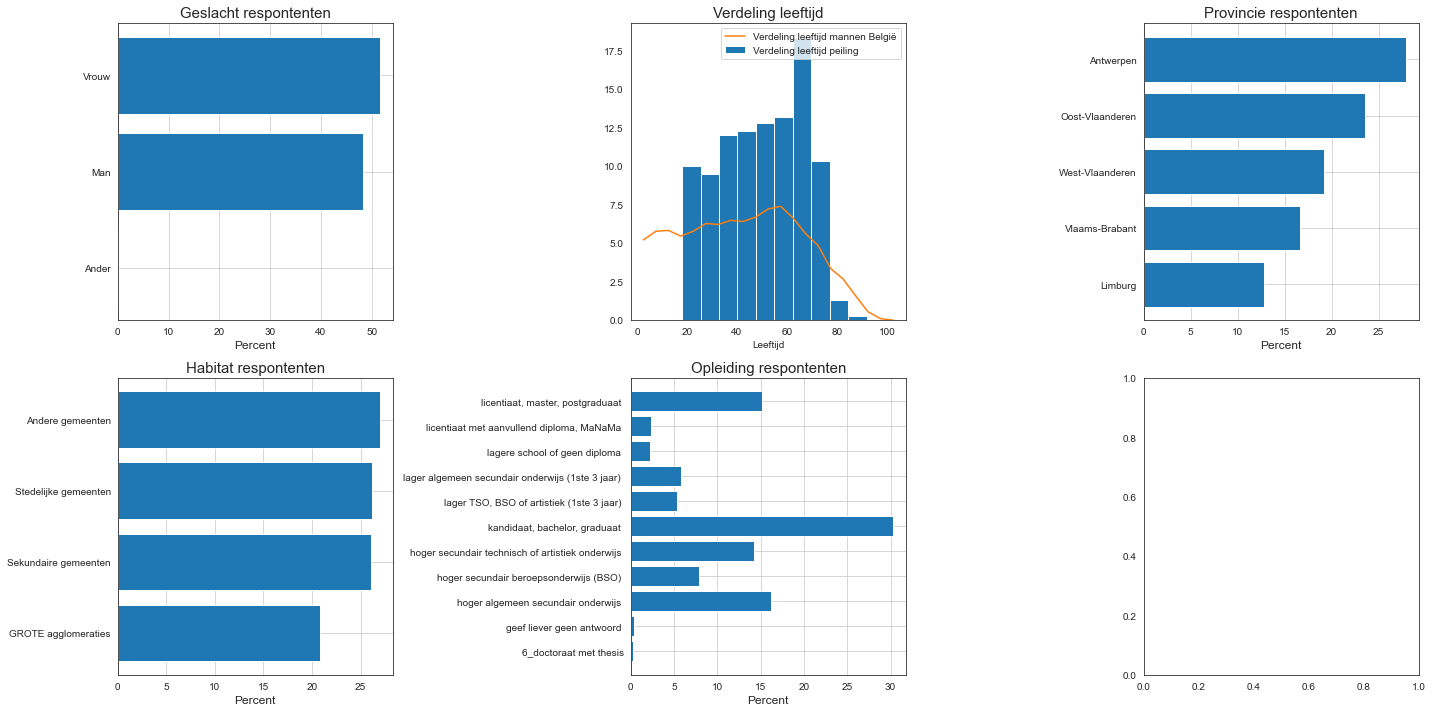

In [26]:
fig, axes = plt.subplots(2,3,figsize=(20,10))

# Value counts sex
geslacht_value_counts = data_raw['Gender'].value_counts(normalize=True).sort_values()*100
axes[0][0].barh(width=geslacht_value_counts.values, y=np.arange(len(geslacht_value_counts)), tick_label=geslacht_value_counts.index.values)
axes[0][0].set_title('Geslacht respontenten', size=15)
axes[0][0].grid()
axes[0][0].set_xlabel('Percent', size=12)

# Histogram age
axes[0][1].hist(x=data_raw['Leeftijd'], weights=(np.zeros_like(data_raw['Leeftijd']) + 1. / data_raw['Leeftijd'].size)*100, label='Verdeling leeftijd peiling')
axes[0][1].set_title('Verdeling leeftijd', size=15)
axes[0][1].plot(leeftijdsverdeling['Leeftijd'], leeftijdsverdeling['Mannen'], label='Verdeling leeftijd mannen België')
axes[0][1].set_xlabel('Leeftijd')
axes[0][1].legend()

# Provincie
provincie_value_counts = data_raw['Provincie'].value_counts(normalize=True).sort_values()*100
axes[0][2].barh(width=provincie_value_counts.values, y=np.arange(len(provincie_value_counts)), tick_label=provincie_value_counts.index.values)
axes[0][2].set_title('Provincie respontenten', size=15)
axes[0][2].grid()
axes[0][2].set_xlabel('Percent', size=12)

# Habitat
habitat_value_counts = data_raw['Habitat'].value_counts(normalize=True).sort_values()*100
axes[1][0].barh(width=habitat_value_counts.values, y=np.arange(len(habitat_value_counts)), tick_label=habitat_value_counts.index.values)
axes[1][0].set_title('Habitat respontenten', size=15)
axes[1][0].grid()
axes[1][0].set_xlabel('Percent', size=12)

# Opleiding
opleiding_value_counts = data_raw['Opleiding'].value_counts(normalize=True).sort_index()*100
axes[1][1].barh(width=opleiding_value_counts.values, y=np.arange(len(opleiding_value_counts)), tick_label=opleiding_value_counts.index.values)
axes[1][1].set_title('Opleiding respontenten', size=15)
axes[1][1].grid()
axes[1][1].set_xlabel('Percent', size=12)



fig.tight_layout()

Text(0.5, 0, 'Percent')

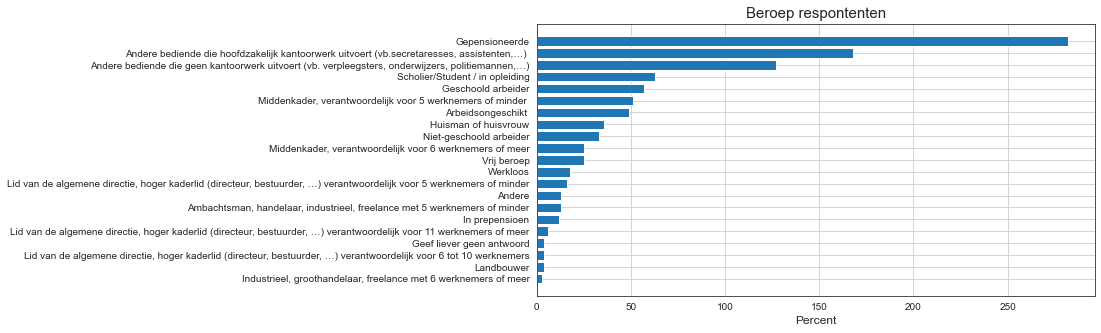

In [27]:
# Beroep
fig, ax = plt.subplots(1,1,figsize=(10,5))

beroep_value_counts = data_raw['Beroep'].value_counts().sort_values()
ax.barh(width=beroep_value_counts.values, y=np.arange(len(beroep_value_counts)), tick_label=beroep_value_counts.index.values)
ax.set_title('Beroep respontenten', size=15)
ax.grid()
ax.set_xlabel('Percent', size=12)

## Politieke voorkeur

In [28]:
data_raw['Voorkeur'] = data_raw['Voorkeur'].replace({
    'PVDA': '1_PVDA',
    'Groen': '2_Groen',
    'Vooruit':'3_Vooruit',
    'CD&V': '4_CD&V',
    'VLD':'5_VLD',
    'N-VA':'6_N-VA',
    'VB': '7_VB',
})

In [57]:
# Filter function
def filter_function(radio_buttons):
    
    # New filtered df
    data_filtered = data_raw.copy()
    data_filtered = data_filtered.loc[~data_filtered['Voorkeur'].isin(['Ander','Weiger','Niet stemmen', 'Weet niet']),:]    
    output.clear_output(wait=True)
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    # Filter geslacht
    if(geslacht_radio_buttons.value in ['Man', 'Vrouw']):
        data_filtered = data_filtered.loc[(data_filtered['Gender'] == geslacht_radio_buttons.value),:]
    
    # Filter provincie
    if(provincie_radio_buttons.value in ['Antwerpen', 'Oost-Vlaanderen', 'West-Vlaanderen', 'Vlaams-Brabant', 'Limburg']):
        data_filtered = data_filtered.loc[(data_filtered['Provincie'] == provincie_radio_buttons.value),:]
    
    # Filter leeftijd
    if(leeftijd_radio_buttons.value=='jonger dan 25'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd']<26,:]
    elif(leeftijd_radio_buttons.value=='26-35'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(25, 35),:]
    elif(leeftijd_radio_buttons.value=='36-45'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(36, 45),:]
    elif(leeftijd_radio_buttons.value=='46-55'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(46, 55),:]
    elif(leeftijd_radio_buttons.value=='56-65'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(56, 65),:]
    elif(leeftijd_radio_buttons.value=='ouder dan 66'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd']>65,:]        
        
    # Show output
    #with output:
    #    display(len(data_filtered))
        
    # Plot
    with output:
        voorkeur_value_counts = data_filtered['Voorkeur'].value_counts(normalize=True).sort_index()*100
        plt.bar(x=np.arange(len(voorkeur_value_counts)), height=voorkeur_value_counts.values, width=0.5, tick_label=voorkeur_value_counts.index)
        plt.grid()
        plt.xticks(rotation = 45)
        plt.title('Voorkeur partij van de responenten\nAantal responenten na filter: {}'.format(len(data_filtered)), size=15)
        plt.ylim(top=40)
        plt.show()
        

# Geslacht radio buttons
geslacht_radio_buttons = widgets.RadioButtons(
    options=['Man', 'Vrouw', 'Beiden'],
    description='Geslacht: ',
    disabled=False
)
geslacht_radio_buttons.observe(filter_function)

# Provincie radio buttons
provincie_radio_buttons = widgets.RadioButtons(
    options=['Antwerpen', 'Oost-Vlaanderen', 'West-Vlaanderen', 'Vlaams-Brabant', 'Limburg', 'Alle'],
    description='Provincie: ',
    disabled=False
)
provincie_radio_buttons.observe(filter_function)

# Leeftijd radiobuttons
leeftijd_radio_buttons = widgets.RadioButtons(
    options=['jonger dan 25', '26-35', '36-45', '46-55', '56-65', 'ouder dan 66', 'Alle'],
    description='Leeftijd: ',
    disabled=False
)
leeftijd_radio_buttons.observe(filter_function)

# HBox with all the filters
input_widgets = widgets.HBox([geslacht_radio_buttons, leeftijd_radio_buttons, provincie_radio_buttons])
display(input_widgets)

# Output
output = widgets.Output()
display(output)
    

Output()

In [99]:
data_raw.sample(5)

,Gender,Leeftijd,Provincie,Habitat,Opleiding,Beroep,Pot Groen,Pot CD&V,Pot N-VA,Pot Vooruit,Pot VB,Pot VLD,Pot PVDA,Voorkeur,Aversie,Stem 2019,Waarom sp.a in 2019 maar nu niet Vooruit?,Waarom niet sp.a in 2019 maar nu wel?,Vertrouwen BEL regering,Vertrouwen De Croo,Vertrouwen VLA regering,Vertrouwen Jambon,Zelf: links-rechts,Groen: links-rechts,CD&V: links-rechts,N-VA: links-rechts,Vooruit: links-rechts,VB: links-rechts,VLD: links-rechts,PVDA: links-rechts,Zelf: progressief,Groen: progressief,CD&V: progressief,N-VA: progressief,Vooruit: progressief,VB: progressief,VLD: progressief,PVDA: progressief,Zelf: conservatief,Groen: conservatief,CD&V: conservatief,N-VA: conservatief,Vooruit: conservatief,VB: conservatief,VLD: conservatief,PVDA: conservatief,Belang thema’s,Economie: eigenaarschap,Klimaat: eigenaarschap,Milieu: eigenaarschap,...,Hilde Crevits: Belangrijke rol,Joachim Coens: Belangrijke rol,Wouter Beke: Belangrijke rol,Annelies Verlinden: Belangrijke rol,Meyrem Almaci: Belangrijke rol,Petra De Sutter: Belangrijke rol,Tom Van Grieken: Belangrijke rol,Dries Van Langenhove: Belangrijke rol,Peter Mertens: Belangrijke rol,Bart De Wever: Belangrijke rol,Jan Jambon: Belangrijke rol,Theo Francken: Belangrijke rol,Ben Weyts: Belangrijke rol,Zuhal Demir: Belangrijke rol,Best vertegenwoordigd,Frank Vandenbroucke: indruk minister,Vincent Van Quickenborne: indruk minister,Alexander De Croo: indruk minister,Wouter Beke: indruk minister,Annelies Verlinden: indruk minister,Jan Jambon: indruk minister,Ben Weyts: indruk minister,Joris Vandenbroucke: Kent u ... ?,Freya Vandenbossche: Kent u ... ?,Astrid De Bruycker: Kent u ... ?,Maxim Veys: Kent u ... ?,Melissa Depraetere: Kent u ... ?,Steve Vandenberghe: Kent u ... ?,Annick Lambrecht: Kent u ... ?,Bruno Tobback: Kent u ... ?,Karin Jiroflee: Kent u ... ?,Mohamed Ridouani: Kent u ... ?,Kris Verduyckt: Kent u ... ?,Ludwig Vandenhove: Kent u ... ?,Els Robeyns: Kent u ... ?,Tom Meeuws: Kent u ... ?,Hannes Anaf: Kent u ... ?,Caroline Gennez: Kent u ... ?,Kathleen Van Brempt: Kent u ... ?,Jinnih Beels: Kent u ... ?,Naamsverandering gehoord?,Bron naamsverandering,Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?,Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?,Waarin verschilt Vooruit volgens u van sp.a?,Overall sentiment,Label positieve woorden Vooruit,Label negatieve woorden Vooruit,Label verschil,Grootste probleem
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1003,Man,52,Vlaams-Brabant,Sekundaire gemeenten,"kandidaat, bachelor, graduaat",Werkloos,Nee,Nee,Ja,Nee,Ja,Nee,Nee,7_VB,"Groen,CD&V,Vooruit,VLD,PVDA",N-VA,NaN,NaN,Helemaal geen vertrouwen,Helemaal geen vertrouwen,Weinig vertrouwen,Weinig vertrouwen,Uiterst rechts,Uiterst links,In het midden,Eerder rechts,Uiterst links,Uiterst rechts,In het midden,Uiterst links,Eerder progressief,Helemaal niet progressief,Helemaal niet progressief,Eerder progressief,Helemaal niet progressief,Eerder progressief,Helemaal niet progressief,Helemaal niet progressief,Eerder niet conservatief,Heel conservatief,Heel conservatief,Eerder niet conservatief,Heel conservatief,Eerder niet conservatief,Heel conservatief,Heel conservatief,"Migratie,Staatshervorming",N-VA,Groen,Groen,...,Nee,Nee,Nee,Nee,Nee,Nee,Ja,Ja,Nee,Ja,Nee,Ja,Nee,Nee,Theo Francken,Slechte indruk,Slechte indruk,Slechte indruk,Slechte indruk,Slechte indruk,Slechte indruk,Slechte indruk,Nee,Ja,Nee,Nee,Nee,Nee,Nee,Ja,Ja,Ja,Nee,Nee,Nee,Nee,Nee,Ja,Ja,Ja,Ja,TV,ge kunt uw naam veranderen maar het (rot)karak...,de meeste rode dromen zijn bedrog,niks noppes nulkommanul,Negatief,Geen,Ontbreekt daadkracht,Geen,de economie die kreunt onder de luiheid van de...
978,Vrouw,64,Oost-Vlaanderen,Stedelijke gemeenten,"licentiaat, master, postgraduaat",Gepensioneerde,Ja,Nee,Ja,Nee,Nee,Nee,Nee,6_N-VA,"VB,PVDA",N-VA,NaN,NaN,Redelijk vertrouwen,Veel vertrouwen,Veel vertrouwen,Veel vertrouwen,In het midden,Eerder links,In het midden,Eerder rechts,Eerder

In [100]:
data_rawdata_raw['Pot PVDA'].value_counts()

Nee    735
Ja     274
Name: Pot PVDA, dtype: int64

## Grootste probleem

RadioButtons(description='Provincie: ', options=('1_PVDA', '2_Groen', '3_Vooruit', '4_CD&V', '5_VLD', '6_N-VA'…

Output()

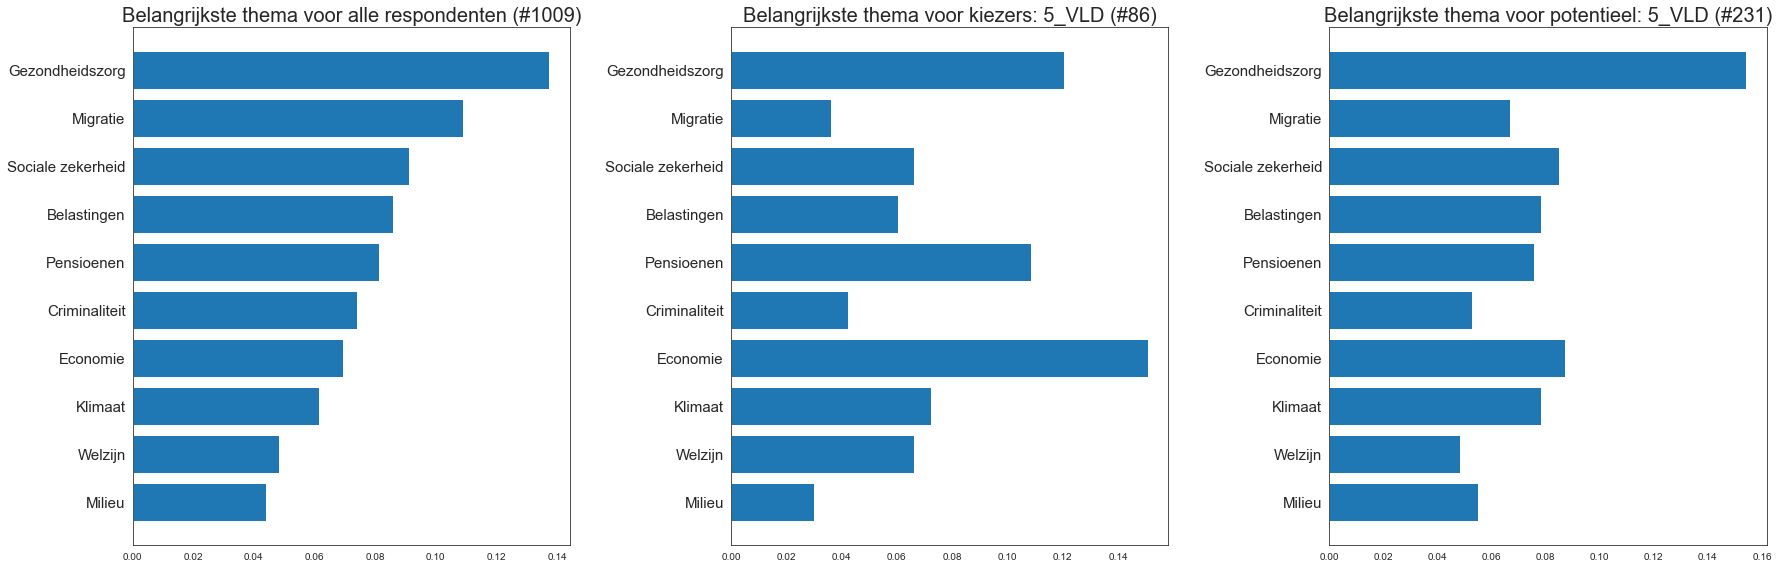

In [121]:
potentieel_column_lookup = {
    '1_PVDA' : 'Pot PVDA',
    '2_Groen': 'Pot Groen', 
    '3_Vooruit': 'Pot Vooruit', 
    '4_CD&V': 'Pot CD&V',
    '5_VLD': 'Pot VLD', 
    '6_N-VA': 'Pot N-VA', 
    '7_VB': 'Pot VB', 
}

def plot_function(partij_radio_buttons):
    
    geselecteerde_partij = partij_radio_buttons.owner.value
    potentieel_column = potentieel_column_lookup[geselecteerde_partij]
    
    # Kiezers
    themas = []
    kiezers = data_raw.loc[(data_raw['Voorkeur']==geselecteerde_partij),:]
    no_print = kiezers['Belang thema’s'].apply(lambda x: themas.extend(x.split(',')))
    themas_value_counts_kiezers = pd.DataFrame(pd.Series(themas).value_counts(normalize=True))
    themas_value_counts_kiezers.columns = [geselecteerde_partij]
    
    # Alle respondenten
    themas = []
    no_print = data_raw['Belang thema’s'].apply(lambda x: themas.extend(x.split(',')))
    themas_value_counts_alle = pd.DataFrame(pd.Series(themas).value_counts(normalize=True))
    themas_value_counts_alle.columns = ['Alle']
    
    # Potentieel
    themas = []
    potentieel = data_raw.loc[(data_raw['Voorkeur']!=geselecteerde_partij) & (data_raw[potentieel_column]=='Ja'),:]
    no_print = potentieel['Belang thema’s'].apply(lambda x: themas.extend(x.split(',')))
    themas_value_counts_potentieel = pd.DataFrame(pd.Series(themas).value_counts(normalize=True))
    themas_value_counts_potentieel.columns = ['Potentieel {}'.format(geselecteerde_partij)]

    # Concat all columns
    themas_value_counts = pd.concat([themas_value_counts_alle, themas_value_counts_kiezers, themas_value_counts_potentieel], axis=1)
    themas_value_counts = themas_value_counts.sort_values('Alle', ascending=False).head(10).sort_values('Alle',ascending=True)
    
    output.clear_output(wait=True)
    fig, axes = plt.subplots(1,3,figsize=(25, 8))
    
    with output:    
        
        axes[0].barh(y=np.arange(len(themas_value_counts)), 
                     width=themas_value_counts['Alle'], 
                     tick_label=themas_value_counts.index)
        axes[0].set_title('Belangrijkste thema voor alle respondenten (#{})'.format(len(data_raw)), size=20)
        axes[0].tick_params(axis='y', labelsize=15)
        
        axes[1].barh(y=np.arange(len(themas_value_counts)), 
                     width=themas_value_counts[geselecteerde_partij], 
                     tick_label=themas_value_counts.index)
        axes[1].set_title('Belangrijkste thema voor kiezers: {} (#{})'.format(geselecteerde_partij, len(kiezers)), size=20)
        axes[1].tick_params(axis='y', labelsize=15)        
        
        axes[2].barh(y=np.arange(len(themas_value_counts)), 
                     width=themas_value_counts['Potentieel {}'.format(geselecteerde_partij)], 
                     tick_label=themas_value_counts.index)
        axes[2].set_title('Belangrijkste thema voor potentieel: {} (#{})'.format(geselecteerde_partij, len(potentieel)), size=20)     
        axes[2].tick_params(axis='y', labelsize=15)
        
        fig.tight_layout()
        
# partij radio buttons
partij_radio_buttons = widgets.RadioButtons(
    options=['1_PVDA', '2_Groen', '3_Vooruit', '4_CD&V', '5_VLD', '6_N-VA', '7_VB'],
    description='Provincie: ',
    disabled=False
)
partij_radio_buttons.observe(plot_function, names=['value'])

display(partij_radio_buttons)

output = widgets.Output()
display(output)


In [134]:
eigenaar_columns = [c for c in data_raw.columns if re.search('eigenaarschap', c)]
data_raw.loc[:,eigenaar_columns] = data_raw.loc[:,eigenaar_columns].replace('PVDA', '1_PVDA')
data_raw.loc[:,eigenaar_columns] = data_raw.loc[:,eigenaar_columns].replace('Groen', '2_Groen')
data_raw.loc[:,eigenaar_columns] = data_raw.loc[:,eigenaar_columns].replace('Vooruit', '3_Vooruit')
data_raw.loc[:,eigenaar_columns] = data_raw.loc[:,eigenaar_columns].replace('CD&V', '4_CD&V')
data_raw.loc[:,eigenaar_columns] = data_raw.loc[:,eigenaar_columns].replace('Open VLD', '5_VLD')
data_raw.loc[:,eigenaar_columns] = data_raw.loc[:,eigenaar_columns].replace('N-VA', '6_N-VA')
data_raw.loc[:,eigenaar_columns] = data_raw.loc[:,eigenaar_columns].replace('Vlaams Belang', '7_VB')

## Eigenaarschap

In [141]:
from IPython.display import clear_output


RadioButtons(description='Provincie: ', index=7, options=('1_PVDA', '2_Groen', '3_Vooruit', '4_CD&V', '5_VLD',…

Output()

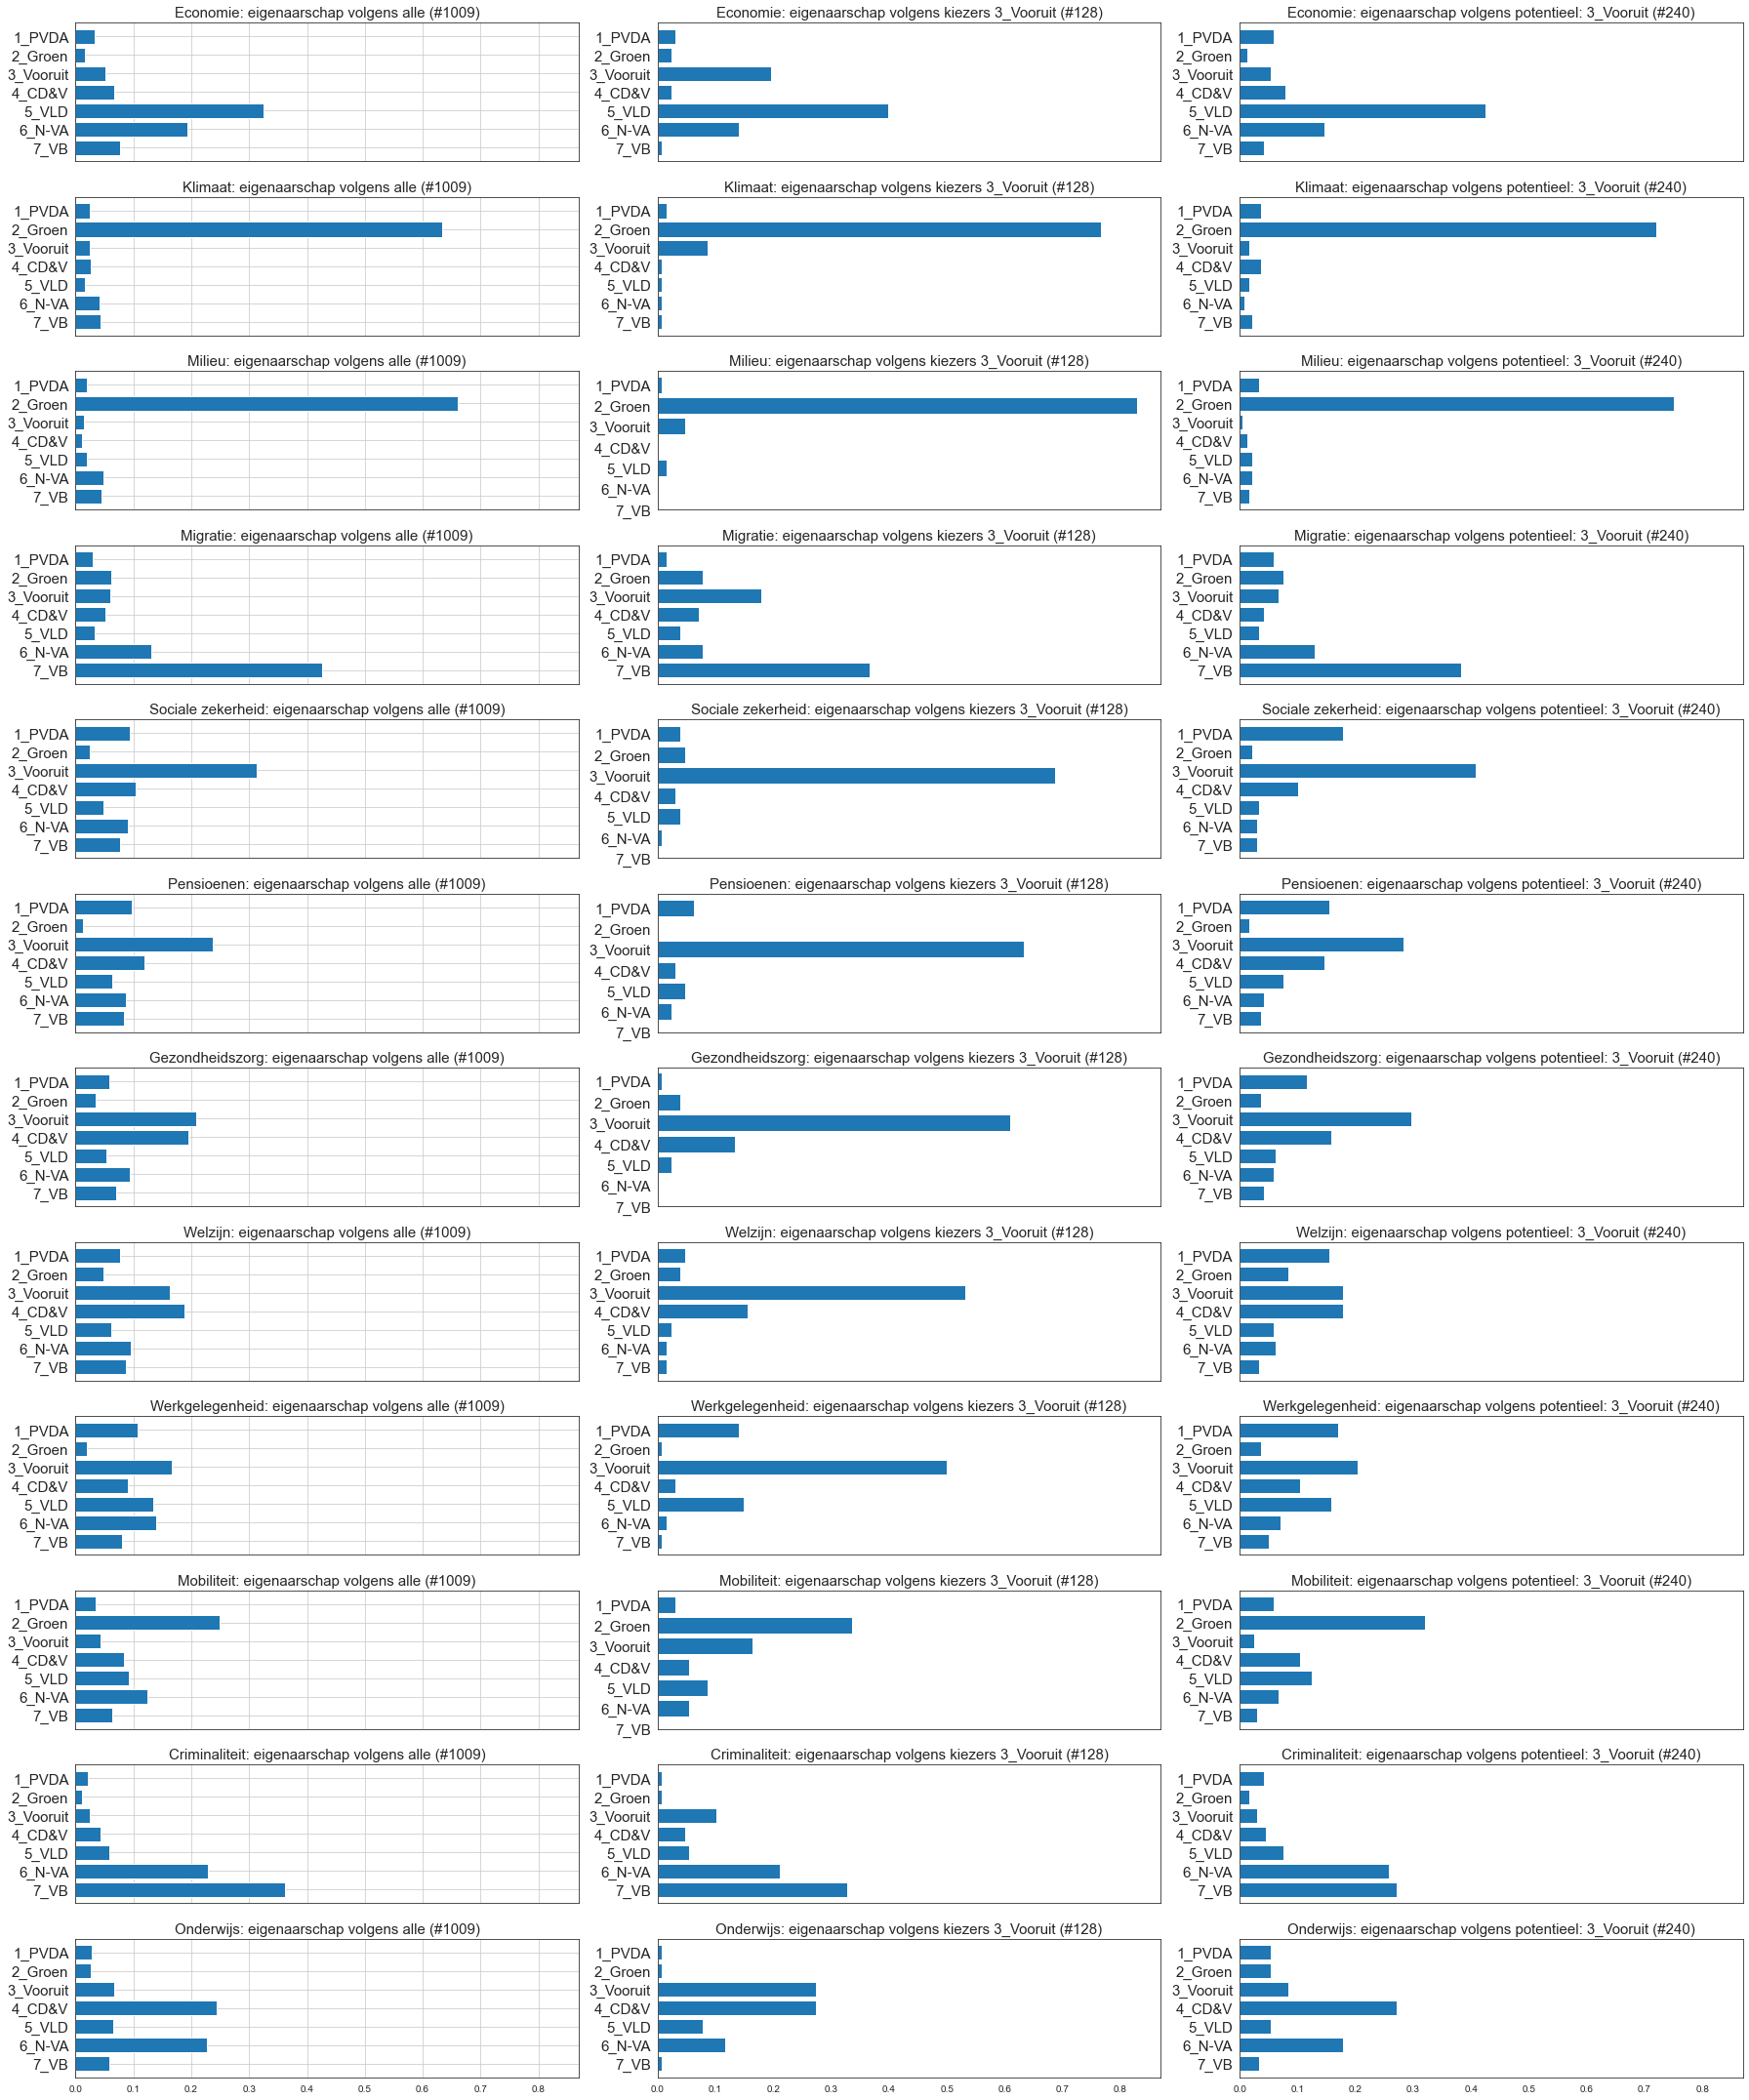

In [148]:
potentieel_column_lookup = {
    '1_PVDA' : 'Pot PVDA',
    '2_Groen': 'Pot Groen', 
    '3_Vooruit': 'Pot Vooruit', 
    '4_CD&V': 'Pot CD&V',
    '5_VLD': 'Pot VLD', 
    '6_N-VA': 'Pot N-VA', 
    '7_VB': 'Pot VB', 
}

def plot_function(partij_radio_buttons):
    
    geselecteerde_partij = partij_radio_buttons.owner.value
    potentieel_column = potentieel_column_lookup[geselecteerde_partij]
    
    kiezers = data_raw.loc[(data_raw['Voorkeur']==geselecteerde_partij),:]
    potentieel = data_raw.loc[(data_raw['Voorkeur']!=geselecteerde_partij) & (data_raw[potentieel_column]=='Ja'),:]
    
    output.clear_output(wait=True)
    fig, axes = plt.subplots(len([c for c in data_raw.columns if re.search('eigenaarschap', c)]),3,figsize=(25, 30), sharex=True)    
    
    for i, column in enumerate([c for c in data_raw.columns if re.search('eigenaarschap', c)]):
        
        # Kiezers
        eigenaar_kiezers_value_counts = pd.DataFrame(kiezers[column].value_counts(normalize=True))
        eigenaar_kiezers_value_counts.columns = [geselecteerde_partij]

        # Alle respondenten
        eigenaar_alle_value_counts = data_raw[column].value_counts(normalize=True)
        eigenaar_alle_value_counts = pd.DataFrame(eigenaar_alle_value_counts)
        eigenaar_alle_value_counts.columns = ['Alle']

        # Potentieel
        eigenaar_potentieel_value_counts = potentieel[column].value_counts(normalize=True)
        eigenaar_potentieel_value_counts = pd.DataFrame(eigenaar_potentieel_value_counts)
        eigenaar_potentieel_value_counts.columns = ['Potentieel {}'.format(geselecteerde_partij)]

        # Concat all columns
        eigenaar_value_counts = pd.concat([eigenaar_kiezers_value_counts, 
                                           eigenaar_alle_value_counts, 
                                           eigenaar_potentieel_value_counts], axis=1)
        eigenaar_value_counts = eigenaar_value_counts.drop(['Weet niet', 'Geen van deze'])
        eigenaar_value_counts = eigenaar_value_counts.sort_index(ascending=False)

        with output:    

            axes[i][0].barh(y=np.arange(len(eigenaar_value_counts)), 
                         width=eigenaar_value_counts['Alle'], 
                         tick_label=eigenaar_value_counts.index)
            axes[i][0].set_title('{} volgens alle (#{})'.format(column,len(data_raw)), size=15)
            axes[i][0].tick_params(axis='y', labelsize=15)
            axes[i][0].grid()

            axes[i][1].barh(y=np.arange(len(eigenaar_value_counts)), 
                         width=eigenaar_value_counts[geselecteerde_partij], 
                         tick_label=eigenaar_value_counts.index)
            axes[i][1].set_title('{} volgens kiezers {} (#{})'.format(column,geselecteerde_partij, len(kiezers)), size=15)
            axes[i][1].tick_params(axis='y', labelsize=15)        
            axes[i][1].grid()
            
            axes[i][2].barh(y=np.arange(len(eigenaar_value_counts)), 
                         width=eigenaar_value_counts['Potentieel {}'.format(geselecteerde_partij)], 
                         tick_label=eigenaar_value_counts.index)
            axes[i][2].set_title('{} volgens potentieel: {} (#{})'.format(column,geselecteerde_partij,
                                                                                        len(potentieel)), size=15)     
            axes[i][2].tick_params(axis='y', labelsize=15)
            axes[i][1].grid()
            
            fig.tight_layout()
        
# partij radio buttons
partij_radio_buttons = widgets.RadioButtons(
    options=['1_PVDA', '2_Groen', '3_Vooruit', '4_CD&V', '5_VLD', '6_N-VA', '7_VB', 'selecteer 1 van bovenstaande'],
    description='Provincie: ',
    disabled=False,
    index=7
)
partij_radio_buttons.observe(plot_function, names=['value'])

display(partij_radio_buttons)

output = widgets.Output()
display(output)


### Clean omschrijvingen

In [30]:
replace_dict = {
    'geen idee':'-',
    '/':'-',
    'geen':'-',
    'weet niet':'-',
    '?':'-',
    'Geen': '-',
    'geen': '-',
    'geen idee': '-',
    '/':'-',
    'Geen idee': '-',
    '?':'-',
    'Weet niet': '-',
    'Niets': '-',
    'geen enkele': '-',
    'niks':'-',
    'geen enkel':'-',
    'weet niet':'-',
    'Niks':'-',
    'geen mening': '-',
    'nihil':'-',
    'GEEN IDEE':'-',
    'GEEN':'',
    'niets':'-',
    'nee':'-',
    'Ik Weet Het Niet':'-',
    'Geen.':'-',
    'Weet Ik Niet': '-',
    'Geen Mening': '-',
    '??':'-',
    '':'-',
    'Nvt':'-',
    'nvt':'-',
    '1':'-',
    'Ik Weet Niet': '-',
    'Ik Zou Het Niet Weten':'-',
    'Weet Niet':'-',
    '????':'-',
    'Zou Niet Weten':'-',
    '......':'-',
    'Heb Er Geen':'-',
    'Kzou Het Niet Weten':'-',
    'weet ik niet':'-',
    'geen.':'-'    
}

data_raw['Grootste probleem is waarmee ons land momenteel wordt geconfronteerd?'] = data_raw['Grootste probleem is waarmee ons land momenteel wordt geconfronteerd?'].str.lower()
data_raw['Grootste probleem is waarmee ons land momenteel wordt geconfronteerd?'] = data_raw['Grootste probleem is waarmee ons land momenteel wordt geconfronteerd?'].replace(replace_dict)
data_raw['Grootste probleem'] = data_raw['Grootste probleem is waarmee ons land momenteel wordt geconfronteerd?']

data_raw['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'] = data_raw['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'].str.lower()
data_raw['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'] = data_raw['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'].replace(replace_dict)

data_raw['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?'] = data_raw['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?'].str.lower()
data_raw['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?'] = data_raw['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?'].replace(replace_dict)

## Positieve woorden om Vooruit te omschrijven

In [31]:
naamwoorden_pos = []
adjectieven_pos = []
row_mask = ((data_raw['Overall sentiment']=='Positief') & (data_raw['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?']!='-'))
for i, beschrijving in enumerate(data_raw.loc[row_mask, 'Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?']):

    #if(i>100): break
    doc = nlp(beschrijving)
    for token in doc:
        if(token.text in ['naam', 'partij']):continue
        if((token.pos_)=='NOUN'): naamwoorden_pos.append(token.text)
        if((token.pos_)=='ADJ'): adjectieven_pos.append(token.text)


### Positieve naamwoorden

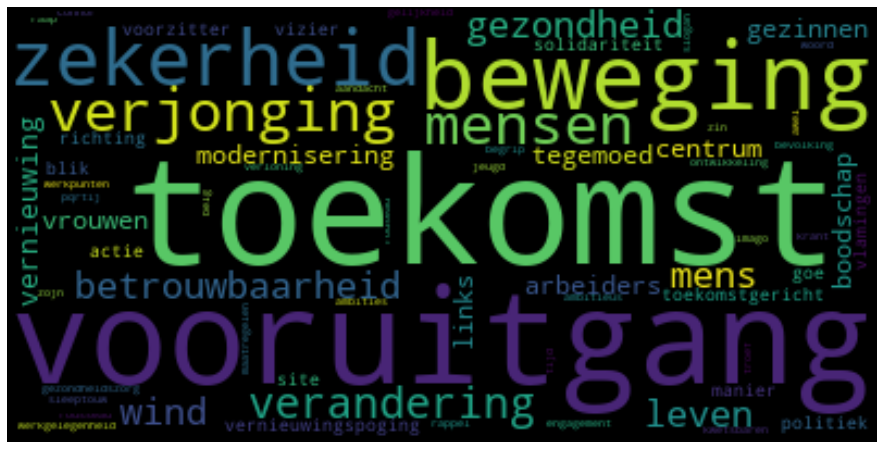

In [32]:
wordcloud = WordCloud().generate(' '.join(naamwoorden_pos))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Positieve adjectieven

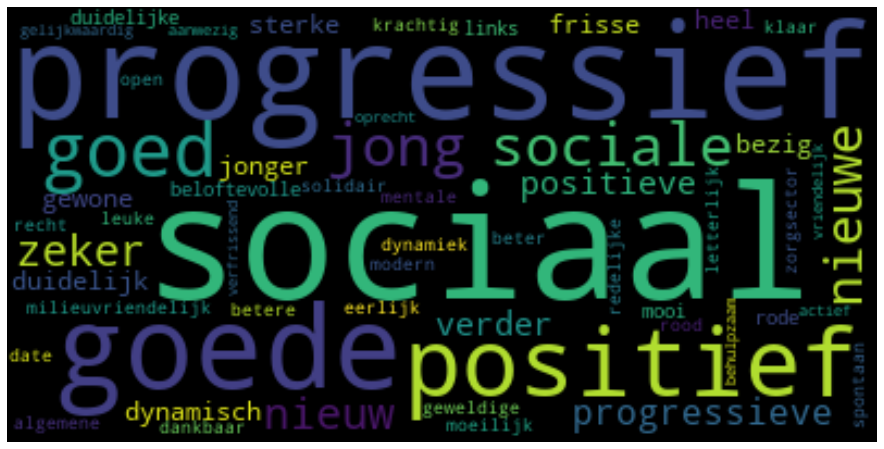

In [33]:
wordcloud = WordCloud().generate(' '.join(adjectieven_pos))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Negatieve woorden om Vooruit te beschrijven

In [34]:
naamwoorden_neg = []
adjectieven_neg = []
row_mask = ((data_raw['Overall sentiment']=='Negatief') & (data_raw['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?']!='-'))
for i, beschrijving in enumerate(data_raw.loc[row_mask, 'Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?']):

    #if(i>100): break
    doc = nlp(beschrijving)
    for token in doc:
        if(token.text in ['naam', 'partij']):continue
        
        if((token.pos_)=='NOUN'): naamwoorden_neg.append(token.text)
        if((token.pos_)=='ADJ'): adjectieven_neg.append(token.text)


### Negatieve naamwoorden

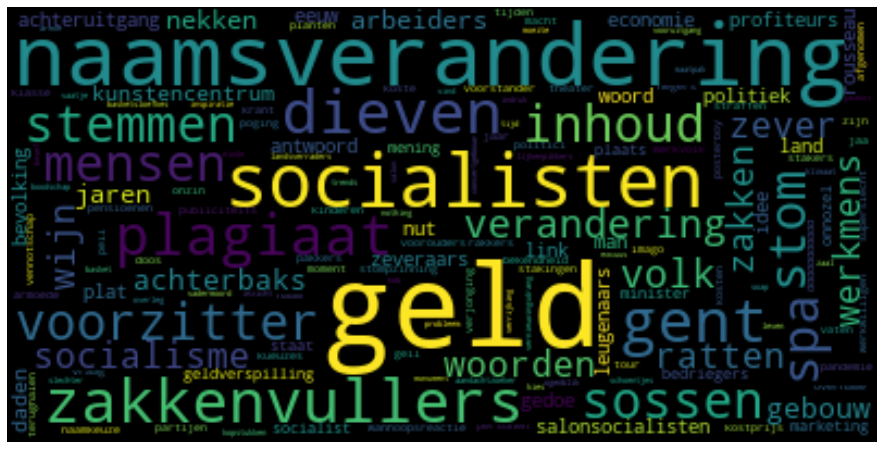

In [35]:
wordcloud = WordCloud().generate(' '.join(naamwoorden_neg))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Negatieve adjectieven

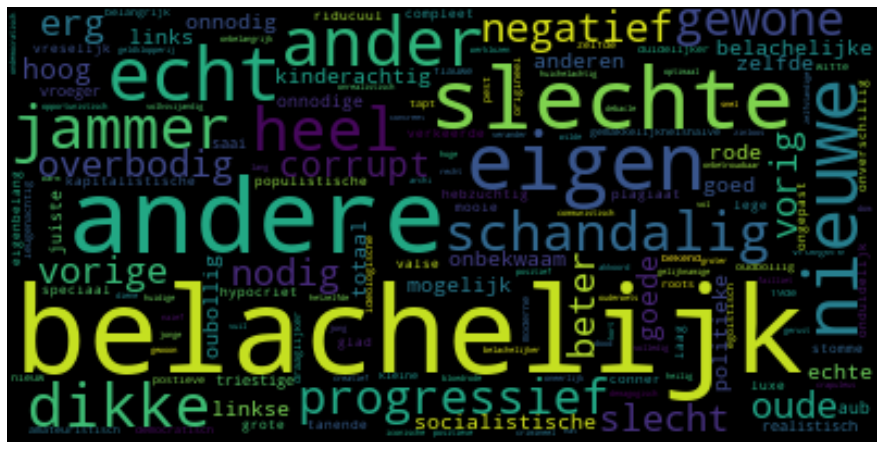

In [36]:
wordcloud = WordCloud().generate(' '.join(adjectieven_neg))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Grootste probleem dit land

In [37]:
replace_dict = {
    'covid':'corona',
    'covid 19':'corona',
    'covid19': 'corona',
    'pandemie':'corona',
    'covid-19':'corona',
    'coronavirus':'corona',
    'de pandemie':'corona',
    'de coronacrisis':'corona',
    'coronacrisis':'corona',
}
data_raw['Grootste probleem'] = data_raw['Grootste probleem'].replace(replace_dict)

In [38]:
row_mask = data_raw['Grootste probleem'].str.contains('corona') | data_raw['Grootste probleem'].str.contains('pandemie') | data_raw['Grootste probleem'].str.contains('covid')
data_raw.loc[row_mask, 'Grootste probleem'] = 'corona'

In [39]:
print('{:.1f}% van de respondenten vind corona het grootste probleem'.format(np.mean(data_raw['Grootste probleem']=='corona')*100))

31.9% van de respondenten vind corona het grootste probleem


In [40]:
row_mask = (data_raw['Grootste probleem'] != 'corona') & (data_raw['Grootste probleem'] != '-')
grootste_problemen = data_raw.loc[row_mask,'Grootste probleem']


In [41]:
naamwoorden_problemen = []
adjectieven_problemen = []
for i, probleem in enumerate(grootste_problemen):

    #if(i>100): break
    doc = nlp(probleem)
    for token in doc:
        if(token.text in ['naam', 'partij']):continue
        
        if((token.pos_)=='NOUN'): naamwoorden_problemen.append(token.text)
        if((token.pos_)=='ADJ'): adjectieven_problemen.append(token.text)


### Naamwoorden grootste problemen

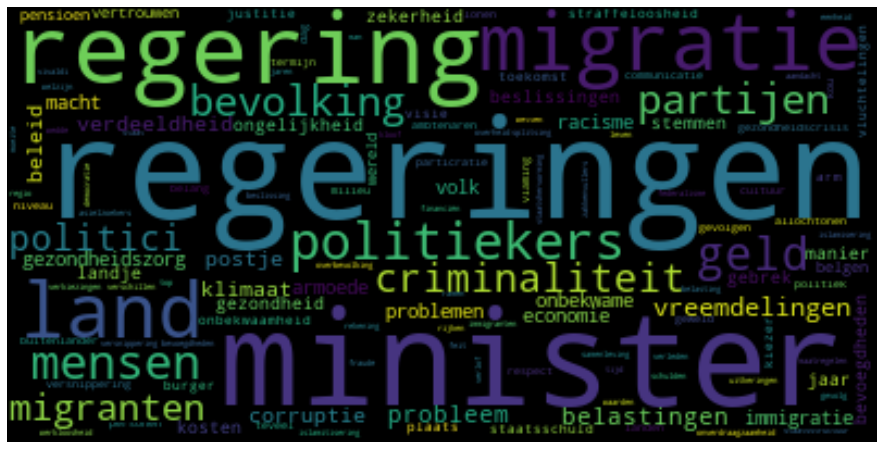

In [42]:
wordcloud = WordCloud().generate(' '.join(naamwoorden_problemen))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Adjectieven grootste problemen

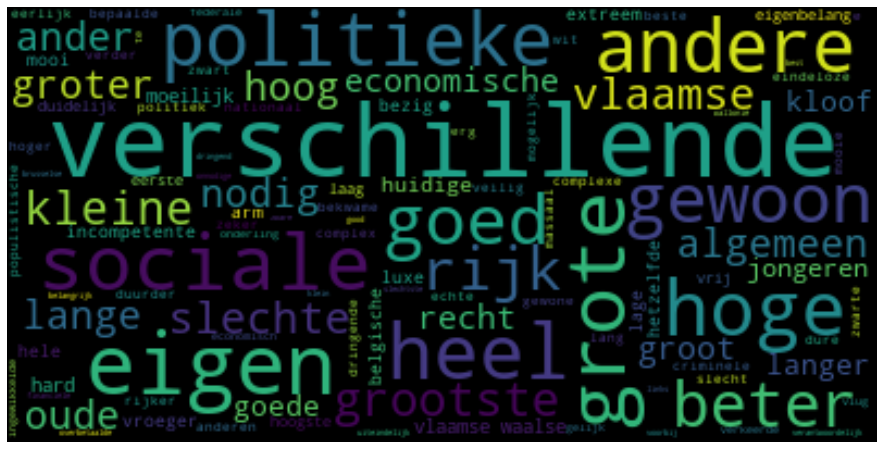

In [43]:
wordcloud = WordCloud().generate(' '.join(adjectieven_problemen))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Interactive grootste problemen

In [44]:
# Filter function
def filter_function(radio_buttons):
        
    # New filtered df
    row_mask = (data_raw['Grootste probleem'] != 'corona') & (data_raw['Grootste probleem'] != '-')
    data_filtered = data_raw.loc[row_mask,:].copy()
    
    #fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    # Filter geslacht
    if(geslacht_radio_buttons.value in ['Man', 'Vrouw']):
        data_filtered = data_filtered.loc[(data_filtered['Gender'] == geslacht_radio_buttons.value),:]
    
    # Filter provincie
    if(provincie_radio_buttons.value in ['Antwerpen', 'Oost-Vlaanderen', 'West-Vlaanderen', 'Vlaams-Brabant', 'Limburg']):
        data_filtered = data_filtered.loc[(data_filtered['Provincie'] == provincie_radio_buttons.value),:]
    
    # Filter leeftijd
    if(leeftijd_radio_buttons.value=='jonger dan 25'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd']<26,:]
    elif(leeftijd_radio_buttons.value=='26-35'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(25, 35),:]
    elif(leeftijd_radio_buttons.value=='36-45'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(36, 45),:]
    elif(leeftijd_radio_buttons.value=='46-55'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(46, 55),:]
    elif(leeftijd_radio_buttons.value=='56-65'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(56, 65),:]
    elif(leeftijd_radio_buttons.value=='ouder dan 66'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd']>65,:]   
    
    # Filter politieke voorkeuren
    if(voorkeuren_radio_buttons.value != 'Alle'):
        data_filtered = data_filtered.loc[(data_filtered['Voorkeur'] == voorkeuren_radio_buttons.value),:]    
        
    # Calculate word cloud
    naamwoorden_problemen = []
    adjectieven_problemen = []
    for i, probleem in enumerate(data_filtered['Grootste probleem']):

        #if(i>100): break
        doc = nlp(probleem)
        for token in doc:
            if(token.text in ['naam', 'partij']):continue

            if((token.pos_)=='NOUN'): naamwoorden_problemen.append(token.text)
            if((token.pos_)=='ADJ'): adjectieven_problemen.append(token.text)    
        
    # Plot
    with output:
        output.clear_output(wait=True)
        print('Wordcloud gebaseerd op {} respondenten (enkel respondenten die iets anders dan Corona antwoordden!)'.format(len(data_filtered)))
        wordcloud = WordCloud().generate(' '.join(naamwoorden_problemen))

        plt.figure(figsize=(20,8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        
        most_occuring = pd.Series(naamwoorden_problemen).value_counts().head(5).index
        
        row_mask = data_filtered['Grootste probleem'].str.contains('|'.join(most_occuring))
        examples = data_filtered.loc[row_mask, 'Grootste probleem'].sample(min(len(data_filtered.loc[row_mask,:]), 10)).values
        print('Voorbeelden')
        print('-----------')
        for example in examples:
            if(len(example)>50):continue
            print(example)
        
#        print(pd.Series(naamwoorden_problemen).value_counts().head(5))
        

# Geslacht radio buttons
geslacht_radio_buttons = widgets.RadioButtons(
    options=['Man', 'Vrouw', 'Beiden'],
    description='Geslacht: ',
    disabled=False,
    value='Beiden',
)
geslacht_radio_buttons.observe(filter_function, names=['value'])

# Provincie radio buttons
provincie_radio_buttons = widgets.RadioButtons(
    options=['Antwerpen', 'Oost-Vlaanderen', 'West-Vlaanderen', 'Vlaams-Brabant', 'Limburg', 'Alle'],
    description='Provincie: ',
    disabled=False,
    value='Alle'
)
provincie_radio_buttons.observe(filter_function, names=['value'])

# Leeftijd radiobuttons
leeftijd_radio_buttons = widgets.RadioButtons(
    options=['jonger dan 25', '26-35', '36-45', '46-55', '56-65', 'ouder dan 66', 'Alle'],
    description='Leeftijd: ',
    disabled=False,
    value='Alle',
)
leeftijd_radio_buttons.observe(filter_function, names=['value'])

# Radio buttons voorkeuren
voorkeuren_options = ['6_N-VA', '5_VLD', '7_VB', '2_Groen', 'Niet stemmen', 'Blanco',
                               '3_Vooruit', '1_PVDA', 'Weet niet', '4_CD&V', 'Weiger', 'Ander', 'Alle']
voorkeuren_options.sort()
voorkeuren_radio_buttons = widgets.RadioButtons(
    options=voorkeuren_options,
    description='Politieke voorkeur:',
    disabled=False,
    value='Alle')
voorkeuren_radio_buttons.observe(filter_function, names=['value'])

# HBox with all the filters
input_widgets = widgets.HBox([geslacht_radio_buttons, leeftijd_radio_buttons, provincie_radio_buttons, voorkeuren_radio_buttons])
display(input_widgets)

# Output
output = widgets.Output()
display(output)
    

Output()

## Potentieel andere partijen

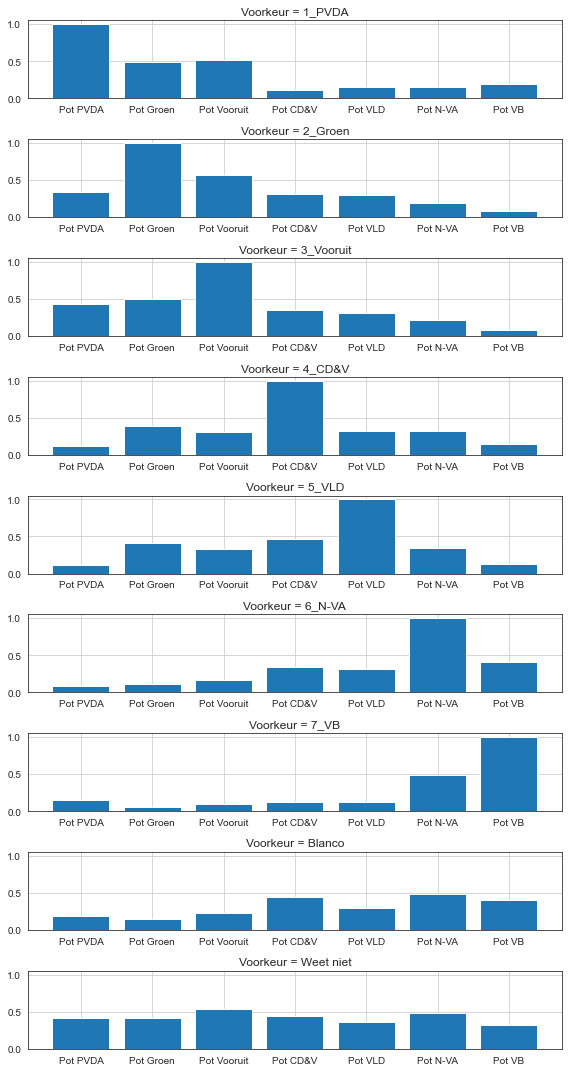

In [45]:
fig, axes = plt.subplots(9,1, figsize=(8,15), sharey=True)

j=0
for i, voorkeur in enumerate(np.unique(data_raw['Voorkeur'])):
    
    if(voorkeur in ['Ander', 'Niet stemmen', 'Weiger']):continue
    
    subset = data_raw.loc[(data_raw['Voorkeur']==voorkeur),:]

    potentieel_groen = np.mean(subset['Pot Groen']=='Ja')
    potentieel_CDV =  np.mean(subset['Pot CD&V']=='Ja')
    potentieel_NVA =  np.mean(subset['Pot N-VA']=='Ja')
    potentieel_Vooruit =  np.mean(subset['Pot Vooruit']=='Ja')
    potentieel_VLD =  np.mean(subset['Pot VLD']=='Ja')
    potentieel_VB =  np.mean(subset['Pot VB']=='Ja')
    potentieel_PVDA =  np.mean(subset['Pot PVDA']=='Ja')
    
    axes[j].bar(x=np.arange(7), height=[potentieel_PVDA, potentieel_groen, potentieel_Vooruit, potentieel_CDV, potentieel_VLD, potentieel_NVA, potentieel_VB], 
                tick_label=['Pot PVDA', 'Pot Groen', 'Pot Vooruit','Pot CD&V', 'Pot VLD','Pot N-VA', 'Pot VB'])
    axes[j].set_title('Voorkeur = '+ voorkeur)
    axes[j].grid()
    
    j+=1
    
fig.tight_layout()

Text(0, 0.5, 'Percentage')

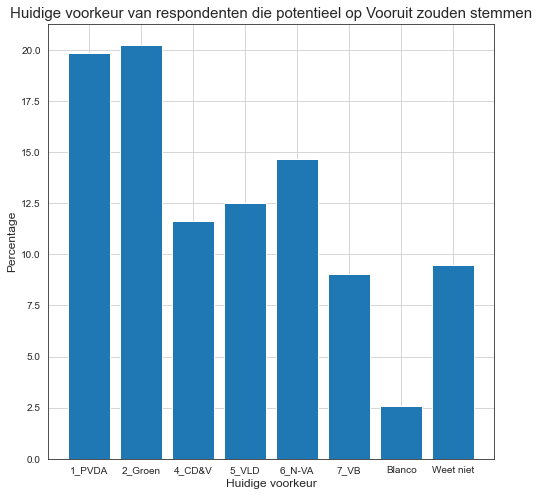

In [46]:
potentieel_vooruit = data_raw.loc[((data_raw['Pot Vooruit']=='Ja') & (~data_raw['Voorkeur'].isin(['3_Vooruit', 'Ander', 'Weiger', 'Niet stemmen']))),:]
potentieel_vooruit = potentieel_vooruit['Voorkeur'].value_counts(normalize=True).sort_index()*100

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.bar(tick_label=potentieel_vooruit.index, 
      x=np.arange(1,9), 
      height=potentieel_vooruit.values)

ax.grid()
ax.set_title('Huidige voorkeur van respondenten die potentieel op Vooruit zouden stemmen', size=15)
ax.set_xlabel('Huidige voorkeur', size=12)
ax.set_ylabel('Percentage', size=12)

## Overall sentiment

Text(0.5, 0, 'Huidige voorkeur')

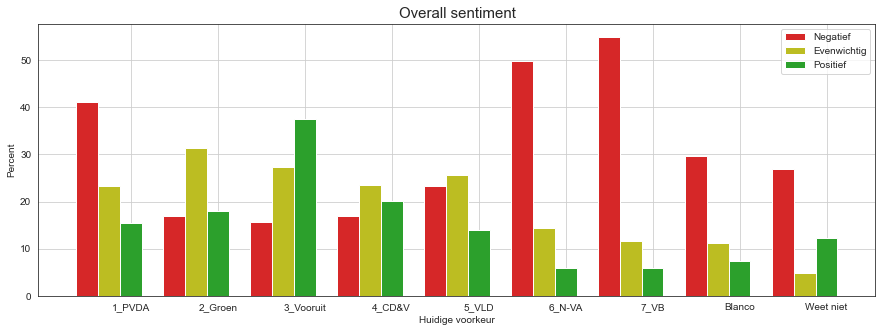

In [47]:
overall_sentiment = data_raw.groupby('Voorkeur')['Overall sentiment'].value_counts(normalize=True)
overall_sentiment = overall_sentiment.reset_index(level=0)
overall_sentiment.columns = ['Voorkeur', 'Percent']
overall_sentiment['Percent'] = overall_sentiment['Percent']*100
overall_sentiment = overall_sentiment.reset_index()

overall_sentiment = overall_sentiment.loc[~overall_sentiment['Voorkeur'].isin(['Weiger', 'Niet stemmen', 'Ander']),:]

fig, ax = plt.subplots(1,1, figsize=(15, 5))

row_mask = (overall_sentiment['Overall sentiment']=='Negatief')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))-0.25, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Negatief', color='C3', width=0.25)

row_mask = (overall_sentiment['Overall sentiment']=='Evenwichtig')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))+0, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Evenwichtig', color='C8', width=0.25)

row_mask = (overall_sentiment['Overall sentiment']=='Positief')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))+0.25, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Positief', color='C2', width=0.25)


ax.set_title('Overall sentiment', size=15)
ax.grid()
ax.legend()
ax.set_ylabel('Percent')
ax.set_xlabel('Huidige voorkeur')


## Positief label

In [48]:
data_copy = data_raw.copy()
data_copy = data_copy.loc[~data_copy['Voorkeur'].isin(['Niet stemmen', 'Weiger', 'Ander'])]
data_copy = data_copy.loc[data_copy['Gender']!='Ander',:]



In [49]:
# Vernieuwend
data_copy['Vernieuwend'] = (data_copy['Label positieve woorden Vooruit'] == 'Innovatie - Vernieuwing')
mean_vernieuwend_per_partij = data_copy.groupby('Voorkeur')['Vernieuwend'].mean()*100

# Sociaal
data_copy['Sociaal'] = (data_copy['Label positieve woorden Vooruit'] == 'Sociaal')
mean_sociaal_per_partij = data_copy.groupby('Voorkeur')['Sociaal'].mean()*100


# Filter function
def filter_function(radio_buttons):
        
    grouped_data_vernieuwed = data_copy.groupby(categorie_radio_buttons.value)['Vernieuwend'].mean()*100
    grouped_data_sociaal = data_copy.groupby(categorie_radio_buttons.value)['Sociaal'].mean()*100
    
    # Plot
    with output:
        
        output.clear_output(wait=True)
        
        fig, axes = plt.subplots(1,2,figsize=(15,5), sharey=True)
        
        axes[0].bar(height=grouped_data_vernieuwed.values, tick_label=grouped_data_vernieuwed.index, x=np.arange(len(grouped_data_vernieuwed)))
        axes[0].grid()
        axes[0].set_title('% van de respondenten die Vooruit vernieuwend vindt', size=15)
        axes[0].set_ylabel('Percent')
        axes[0].set_xlabel(categorie_radio_buttons.value)

        axes[1].bar(height=grouped_data_sociaal.values, tick_label=grouped_data_sociaal.index, x=np.arange(len(grouped_data_sociaal)))
        axes[1].grid()
        axes[1].set_title('% van de respondenten die Vooruit sociaal vindt', size=15)
        axes[1].set_ylabel('Percent')
        axes[1].set_xlabel(categorie_radio_buttons.value)

        fig.autofmt_xdate(rotation=45 )        
        
# Categorie buttons
categorie_radio_buttons = widgets.RadioButtons(
    options=['Voorkeur', 'Gender', 'Provincie'],
    description='Categorie: ',
    disabled=False,
    value='Voorkeur',
)
categorie_radio_buttons.observe(filter_function, names=['value'])

# HBox with all the filters
input_widgets = widgets.HBox([categorie_radio_buttons])
display(input_widgets)



# Output
output = widgets.Output()
display(output)
    


Output()

In [50]:
for i, label in enumerate((data_raw['Label positieve woorden Vooruit'].value_counts().index)):
    if(label in ['Geen', 'Ongeldig', 'Geen idee']): continue
    
    subset = data_raw.loc[data_raw['Label positieve woorden Vooruit']==label,:]
    print('\n')
    print(label + ' (totaal: {})'.format(len(subset)))
    print('-----------------')
    
    for to_print in subset['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'].sample(min(5, len(subset))).values:
        print(to_print)



Innovatie - Vernieuwing (totaal: 114)
-----------------
vernieuwing
dynamischer
modern en vooruitstrevend
dat ons land vooruit moet
progressief


Sociaal (totaal: 49)
-----------------
rood
sociaal beroerd
sociaal
menselijk, verdraagzaam
sociaal


Gedrag: Gedreven (totaal: 28)
-----------------
willen vooruit
vpooruit
ze willen verder
we doen het
sociaal, gedreven


Brand identity: naam (totaal: 19)
-----------------
eens een begrip
duidelijke boodschap
het woord op zichzelf is ok...maar de politieke strekking van spa is totaal achteruitgang voor het land zoals ze reeds jaren bewezen hebben !!!!!zal nu niet anders zijn de tijd dat de socialisten op kwamen is reeds lang voorbij gestreefd!!!!!! we leven nu op een andere manier en de werkende bevolking heeft enorm veel voordelen !!!!!!
positief  voordeel
frisse naam


Leiderschap: Toekomstgericht (totaal: 19)
-----------------
vooruit kijken en niet achteruit
het wordt een beweging met het vizier op de toekomst waarmee alle progressieve

## Negatief label

In [51]:
# Vernieuwend
data_copy['Gestolen_naam'] = (data_copy['Label negatieve woorden Vooruit'] == 'Gestolen naam')

# Sociaal
data_copy['Marketingstunt'] = (data_copy['Label negatieve woorden Vooruit'] == 'Marketingstunt')


# Filter function
def filter_function(radio_buttons):
        
    grouped_data_gestolen_naam = data_copy.groupby(categorie_radio_buttons.value)['Gestolen_naam'].mean()*100
    grouped_data_marketing_stunt = data_copy.groupby(categorie_radio_buttons.value)['Marketingstunt'].mean()*100
    
    # Plot
    with output:
        
        output.clear_output(wait=True)
        
        fig, axes = plt.subplots(1,2,figsize=(15,5), sharey=True)
        
        axes[0].bar(height=grouped_data_gestolen_naam.values, tick_label=grouped_data_gestolen_naam.index, x=np.arange(len(grouped_data_gestolen_naam)))
        axes[0].grid()
        axes[0].set_title('% van de respondenten die Vooruit gestolen naam vindt', size=15)
        axes[0].set_ylabel('Percent')
        axes[0].set_xlabel(categorie_radio_buttons.value)

        axes[1].bar(height=grouped_data_marketing_stunt.values, tick_label=grouped_data_marketing_stunt.index, x=np.arange(len(grouped_data_marketing_stunt)))
        axes[1].grid()
        axes[1].set_title('% van de respondenten die Vooruit marketingsunt vindt', size=15)
        axes[1].set_ylabel('Percent')
        axes[1].set_xlabel(categorie_radio_buttons.value)

        fig.autofmt_xdate(rotation=45 )        
        
# Categorie buttons
categorie_radio_buttons = widgets.RadioButtons(
    options=['Voorkeur', 'Gender', 'Provincie'],
    description='Categorie: ',
    disabled=False,
    value='Voorkeur',
)
categorie_radio_buttons.observe(filter_function, names=['value'])

# HBox with all the filters
input_widgets = widgets.HBox([categorie_radio_buttons])
display(input_widgets)



# Output
output = widgets.Output()
display(output)
    


Output()

In [52]:
for i, label in enumerate((data_raw['Label negatieve woorden Vooruit'].value_counts().index)):
    if(label in ['Geen', 'Ongeldig', 'Geen idee']): continue
    
    subset = data_raw.loc[data_raw['Label negatieve woorden Vooruit']==label,:]
    print('\n')
    print(label + ' (totaal: {})'.format(len(subset)))
    print('-----------------')
    
    for to_print in subset['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?'].sample(min(5, len(subset))).values:
        print(to_print)



Gestolen naam (totaal: 86)
-----------------
dieven een poging om te teren op de bekendheid van hun nieuwe naam
discussie met kunstencentrum
naam van kunstencentrum vooruit claimen
beetje misplaatst om een bestaande naam te gebruiken
de naam werd gestolen van zaal vooruit in gent


Marketingstunt (totaal: 61)
-----------------
men tapt nog steeds uit zélfde vaatje
er is door die naamsverandering niets concreets veranderd aan deze partij
zelfde zever in andere verpakking.
blijven rode rakkers
het is niet omdat je iets in een ander kleedje stopt, dat er ook echt iets veranderd


Slechte naamkeuze (totaal: 41)
-----------------
heb ik reeds gedaan . het trekt op niks die naamsverandering.
verwarrend
doet nogal denken aan de feestzaal vooruit, hierdoor kan er verwarring ontstaan
slechte naam
moesten andere naam gekozen hebben


Alles (totaal: 41)
-----------------
alles.
trekt op niets
alles
alles
belachelijk


Ontbreekt daadkracht (totaal: 40)
-----------------
wat maakt een naam veel u

## Gevoelens van potentieel kiezers Vooruit

In [53]:
row_mask = (data_raw['Pot Vooruit']=='Ja')
pot_vooruit = data_raw.loc[row_mask,:].copy()

Text(0.5, 0, 'Huidige voorkeur')

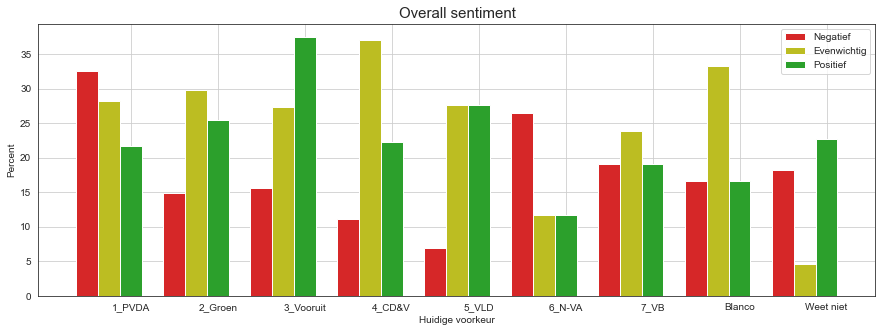

In [54]:
overall_sentiment = pot_vooruit.groupby('Voorkeur')['Overall sentiment'].value_counts(normalize=True)
overall_sentiment = overall_sentiment.reset_index(level=0)
overall_sentiment.columns = ['Voorkeur', 'Percent']
overall_sentiment['Percent'] = overall_sentiment['Percent']*100
overall_sentiment = overall_sentiment.reset_index()

overall_sentiment = overall_sentiment.loc[~overall_sentiment['Voorkeur'].isin(['Weiger', 'Niet stemmen', 'Ander']),:]

fig, ax = plt.subplots(1,1, figsize=(15, 5))

row_mask = (overall_sentiment['Overall sentiment']=='Negatief')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))-0.25, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Negatief', color='C3', width=0.25)

row_mask = (overall_sentiment['Overall sentiment']=='Evenwichtig')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))+0, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Evenwichtig', color='C8', width=0.25)

row_mask = (overall_sentiment['Overall sentiment']=='Positief')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))+0.25, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Positief', color='C2', width=0.25)


ax.set_title('Overall sentiment', size=15)
ax.grid()
ax.legend()
ax.set_ylabel('Percent')
ax.set_xlabel('Huidige voorkeur')


In [55]:


for i, label in enumerate((pot_vooruit['Label positieve woorden Vooruit'].value_counts().index)):
    if(label in ['Geen', 'Ongeldig', 'Geen idee']): continue
    
    subset = pot_vooruit.loc[pot_vooruit['Label positieve woorden Vooruit']==label,:]
    print('\n')
    print(label + ' (totaal: {})'.format(len(subset)))
    print('-----------------')
    
    for to_print in subset['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'].sample(min(5, len(subset))).values:
        print(to_print)



Innovatie - Vernieuwing (totaal: 65)
-----------------
men wil weer vooruit gaan en niet blijven stilstaan.
dat ons land vooruit moet
samen vooruit
vooruitstrevend - vernieuwend - strijdbaar
ik hoop dat ze ook vooruit gaan ... waarom veranderen anders?


Sociaal (totaal: 29)
-----------------
goede socialistische partije
sociaal bewogen
back to the roots
sociaal
sociaal bewogen


Gedrag: Gedreven (totaal: 15)
-----------------
sociaal geëngageerd, wil verder
ze willen vooruit maar afwachten of dat zo zal zijn.
vpooruit
beter doen
gemotiveerd


Leiderschap: Toekomstgericht (totaal: 10)
-----------------
positief denken
vooruit is klaar en duidelijk. men wilt vooruit naar de toekomst kijken. niet talmen. niet zeggen maar doen.
toekomstgericht
toekomstgericht
moet positief zojn


Brand identity: naam (totaal: 9)
-----------------
leuke en sterke naam
geen afkorting meer
duidelijke boodschap
een goede slogan en een rappel van de krant
het komt overeen met hun verleden, namelijk de social

In [56]:
# TO DO
# ---
# Kernthema's optellen
# DG: Doelgroep
# Verschil SPA - Vooruit, ook kijken naar label
